# Analyze network consequences of protein abundance changes - PCMT1
Currently set up for a single model
## Setup
### Import packages

In [1]:
from pathlib import Path
from collections import defaultdict
from operator import attrgetter
from warnings import warn
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from cobra.flux_analysis import find_blocked_reactions
from cobra.flux_analysis.variability import flux_variability_analysis
from rbc_gem_utils import (
    get_dirpath,
    COBRA_CONFIGURATION,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    ProteinDilution,
    ComplexDilution,
    ComplexForm,
    EnzymeForm,
    EnzymeDilution,
    Protein,
    Complex,
    Enzyme,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL, DEFAULT_VOLUME_PER_CELL

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)
gp.setParam("NumericFocus", 1)
gp.setParam("Quad", 1)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664189

Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
gurobipy                             11.0.1
matplotlib                            3.8.2
matplotlib-venn                       1.1.1
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues due to protein constraint bounds
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-09
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRedOmics"

### Set computation options

In [4]:
protein_of_interest = "PCMT1"
reaction_of_interest = "PROTISODMT_L"

protein_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.dilution"]
protein_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.metabolite"]
relax_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.relaxation"]

budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]

enzyme_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.metabolite"]
enzyme_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.dilution"]
enzyme_form_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.formation"]

enzyme_fwd_suffix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.forward"]
enzyme_rev_suffix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.reverse"]
enzyme_tot_suffix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.total"]

### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load RBC-GEM model

In [6]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id

results_dirpath = get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name

fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
abundance_change_results_path = results_dirpath / "abundance_changes"

# Ensure directories exist
abundance_change_results_path.mkdir(exist_ok=True, parents=True)

model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=sample_pcmodels_dirpath / f"{model_id}_PC_{dataset_name}.xml")
pcmodel

Name,RBC_GEM_PC_DeepRedOmics
Memory address,14d2edb50
Number of metabolites,10411
Number of reactions,19620
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


In [7]:
protein_gene = pcmodel.genes.get_by_id(protein_of_interest)

biochemical_reactions = []
for reaction in sorted(protein_gene.reactions, key=attrgetter("id")):
    if reaction in model.reactions:
        print(model.reactions.get_by_id(reaction.id))
        biochemical_reactions += [reaction.id]


# Get protein metabolite and dilution reaction
protein_met = pcmodel.metabolites.get_by_id(f"{protein_met_prefix}{protein_of_interest}_pc")
protein_rxn = pcmodel.reactions.get_by_id(f"{protein_rxn_prefix}{protein_met.id}")

# Get complex metabolite(s)
cplx_mets = [
    x.products[0] for x in protein_met.reactions 
    if isinstance(x, ComplexForm)
]

enzyme_form_rxns = [
    x for cplx_met in cplx_mets
    for x in cplx_met.reactions
    if isinstance(x, EnzymeForm)
]

# Store IDs for later use
protein_mid = protein_met.id
protein_rid = protein_rxn.id
protein_relax_id = f"{relax_rxn_prefix}{protein_mid}"

cplx_mids = [cplx_met.id for cplx_met in cplx_mets]
enzyme_form_rids = [x.id for x in enzyme_form_rxns]
enzyme_mids = {
    rid: [
        x.id for x in pcmodel.reactions.get_by_id(rid).metabolites 
        if isinstance(x, Enzyme)
    ] 
    for rid in biochemical_reactions
}


protein_gene

PROTDMT_D: amet__L_c + protres_asp__D_c --> ahcys__L_c + protres_aspmeo__D_c
PROTISODMT_L: amet__L_c + protres_isoasp__L_c --> ahcys__L_c + protres_isoaspmeo__L_c


Gene identifier,PCMT1
Name,PCMT1
Memory address,0x14fa62f90
Functional,True
In 13 reaction(s),"ENZFM_enzyme_PROTDMT_D_fwd_cplx_MONOMER_PCMT1_pc, ENZDL_enzyme_PROTDMT_D_rev_pc, ENZDL_enzyme_PROTISODMT_L_rev_pc, CPLXFM_cplx_MONOMER_PCMT1_pc, CPLXDL_cplx_MONOMER_PCMT1_pc,..."


### Get original values from model

In [8]:
budget_met_relax = pcmodel.metabolites.get_by_id(f"{budget_met_prefix}relaxation")
budget_rxn_relax = pcmodel.reactions.get_by_id(f"{budget_rxn_prefix}{budget_met_relax}")

orig_relax_budget = budget_rxn_relax.bounds
orig_protein_bounds = protein_rxn.bounds

### Minimize relaxation budget

In [9]:
print("Old relaxation bounds: ({:.6f}, {:.6f})".format(*orig_relax_budget))
# update_slack_value(pcmodel, 1, verbose=True)

relaxdl_reaction = pcmodel.reactions.get_by_id(f"{relax_rxn_prefix}{protein_met_prefix}{protein_of_interest}_pc")
relaxdl_reaction.bounds = (0, 0)

budget_rxn_relax.upper_bound = orig_relax_budget[0]
print("New relaxation bounds: ({:.6f}, {:.6f})".format(*budget_rxn_relax.bounds))

Old relaxation bounds: (0.001928, 5.041332)
New relaxation bounds: (0.001928, 0.001928)


### Ensure model can optimize all reactions catalyzed by protein of interest

In [10]:
objective_reactions = [reaction_of_interest]
pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
sol = pcmodel.optimize(raise_error=True)

# Display solution for objective fluxes
objective_sol = sol.fluxes.loc[objective_reactions + [
    "SK_protres_isoasp__L_c",
    "SK_protres_isoasp__D_c",
    "SK_protres_asp__L_c",
    "SK_protres_asp__D_c",
    "SK_protres_asn__L_c",
]]
print(f"Optimization objective: {sol.objective_value:.6f}\n{objective_sol}")
# Protein utilized
protein_sol = sol.fluxes.loc[[protein_rid, protein_relax_id]]
print(f"\nProtein utilized: {protein_sol.sum():.6f}\n{protein_sol}")
# Required relaxation budget
relax_sol = sol.fluxes.loc[pcmodel.reactions.query(lambda x: x.id.startswith("RELAX_") or x.id.endswith(budget_met_relax.id)).list_attr("id")]
relax_sol = relax_sol[relax_sol != 0]
relax_budget_used = relax_sol.loc[budget_rxn_relax.id]
print(f"\nTotal relaxation budget utilized: {relax_budget_used:.6f} ({relax_budget_used / budget_rxn_relax.upper_bound:.4%})\n{relax_sol}")

Optimization objective: 0.005612
PROTISODMT_L              0.005612
SK_protres_isoasp__L_c    0.000000
SK_protres_isoasp__D_c    0.000000
SK_protres_asp__L_c       0.000000
SK_protres_asp__D_c       0.000000
SK_protres_asn__L_c       0.000000
Name: fluxes, dtype: float64

Protein utilized: 3.716592
PROTDL_protein_PCMT1_pc    3.716592
RELAX_protein_PCMT1_pc     0.000000
Name: fluxes, dtype: float64

Total relaxation budget utilized: 0.001928 (100.0000%)
BDL_budget_relaxation      0.001928
RELAX_protein_SLC7A5_pc    0.012240
RELAX_protein_TSPO2_pc     0.065577
Name: fluxes, dtype: float64


#### Add boundary reactions to control substrate and product availability
Required to explore reactions/proteins that are abundance-independent

In [11]:
SK_protres_isoasp__L_c = pcmodel.reactions.SK_protres_isoasp__L_c
DM_protres_isoaspmeo__L_c = pcmodel.add_boundary(
    pcmodel.metabolites.protres_isoaspmeo__L_c,
    type="demand",
    lb=0,
    ub=1000,
)
DM_ahcys__L_c = pcmodel.add_boundary(
    pcmodel.metabolites.ahcys__L_c,
    type="demand",
    lb=0,
    ub=1000,
)
SK_amet__L_c = pcmodel.add_boundary(
    pcmodel.metabolites.amet__L_c,
    type="sink",
    lb=-1000,
    ub=1000,
)

pcmodel.reactions.SK_protres_isoasp__L_c.bounds = (-1000, 1000)
pcmodel.reactions.SK_amet__L_c.bounds = (0, 0)
pcmodel.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 1000)
pcmodel.reactions.DM_ahcys__L_c.bounds = (0, 0)

In [12]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
    "PROTDL_protein_MAT2A_pc",
    "RELAX_protein_MAT2A_pc",
    "PROTDL_protein_MAT2B_pc",
    "RELAX_protein_MAT2B_pc",
    "RELAX_protein_AHCY_pc",
    "PROTDL_protein_AHCY_pc",
]
biochemical_rxns_of_interest = [
    "METAT", 
    "AHC",
    "SK_protres_isoasp__L_c",
    "SK_protres_asp__L_c",
]
objective_reactions = [reaction_of_interest]


solutions = []
with pcmodel:
    pcmodel.reactions.SK_protres_isoasp__L_c.bounds = (-1000, 1000)
    pcmodel.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 1000)
    pcmodel.reactions.SK_amet__L_c.bounds = (0, 0)
    pcmodel.reactions.DM_ahcys__L_c.bounds = (0, 0)
    protein_reaction = pcmodel.reactions.get_by_id(protein_rid)
    pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
    
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
METAT,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,...,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.000000
AHC,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,...,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.000000
SK_protres_isoasp__L_c,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,...,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,-0.002423,0.000000
SK_protres_asp__L_c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTISODMT_L,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,...,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.000000
PROTDL_protein_PCMT1_pc,3.716592,3.679426,3.642260,3.605094,3.567928,3.530762,3.493597,3.456431,3.419265,3.382099,...,0.334493,0.297327,0.260161,0.222996,0.185830,0.148664,0.111498,0.074332,0.037166,0.000000
RELAX_protein_PCMT1_pc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_MAT2A_pc,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,...,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593
RELAX_protein_MAT2A_pc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_MAT2B_pc,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,...,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796,0.085796


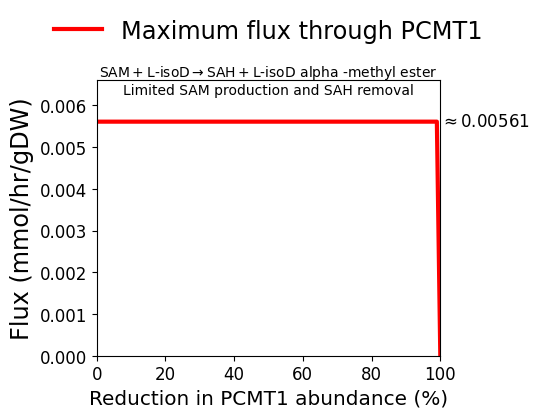

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
PROTISODMT_L_flux = df_solutions.loc[["PROTISODMT_L"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
PROTISODMT_L_flux.index *= -1
PROTISODMT_L_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=3, 
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    "$\\text{SAM} + \\text{L-isoD} \\rightarrow \\text{SAH} + \\text{L-isoD}\ \\text{\\alpha -methyl ester}$" 
    "\nLimited SAM production and SAH removal",
    xy=(0.5, 1.00),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="medium"
)


xpad = 0
ypad = 0.001
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(0, PROTISODMT_L_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")


ymax = PROTISODMT_L_flux.max()
ax.annotate(
    approx_label_fmt.format(ymax), 
    xy=(100, ymax * 0.98), 
    xycoords="data",
    fontsize="large"
)

fig.tight_layout()
if save_figures:
    ftypes = ["png", "svg"]
    for ftype in ftypes:
        fig.savefig(
            abundance_change_results_path 
            / f"Reduction_{protein_of_interest}_PanelA.{ftype}", 
            transparent=transparent, 
            format=ftype
        )

In [14]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
    "PROTDL_protein_MAT2A_pc",
    "RELAX_protein_MAT2A_pc",
    "PROTDL_protein_MAT2B_pc",
    "RELAX_protein_MAT2B_pc",
    "RELAX_protein_AHCY_pc",
    "PROTDL_protein_AHCY_pc",
]
biochemical_rxns_of_interest = ["METAT", "AHC", "SK_protres_isoasp__L_c", "SK_amet__L_c", "DM_protres_isoaspmeo__L_c", "DM_ahcys__L_c"]
objective_reactions = [reaction_of_interest]


solutions = []
with pcmodel:
    pcmodel.reactions.SK_protres_isoasp__L_c.bounds = (-1000, 1000)
    pcmodel.reactions.SK_amet__L_c.bounds = (-1000, 0)
    pcmodel.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 1000)
    pcmodel.reactions.DM_ahcys__L_c.bounds = (0, 1000)
    protein_reaction = pcmodel.reactions.get_by_id(protein_rid)
    pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
METAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AHC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SK_protres_isoasp__L_c,-2.729321,-2.702028,-2.674735,-2.647442,-2.620149,-2.592855,-2.565562,-2.538269,-2.510976,-2.483682,...,-0.245639,-0.218346,-0.191052,-0.163759,-0.136466,-0.109173,-0.081880,-0.054586,-0.027293,0.000000
SK_amet__L_c,-2.729321,-2.702028,-2.674735,-2.647442,-2.620149,-2.592855,-2.565562,-2.538269,-2.510976,-2.483682,...,-0.245639,-0.218346,-0.191052,-0.163759,-0.136466,-0.109173,-0.081880,-0.054586,-0.027293,0.000000
DM_protres_isoaspmeo__L_c,2.729321,2.702028,2.674735,2.647442,2.620149,2.592855,2.565562,2.538269,2.510976,2.483682,...,0.245639,0.218346,0.191052,0.163759,0.136466,0.109173,0.081880,0.054586,0.027293,0.000000
DM_ahcys__L_c,2.729321,2.702028,2.674735,2.647442,2.620149,2.592855,2.565562,2.538269,2.510976,2.483682,...,0.245639,0.218346,0.191052,0.163759,0.136466,0.109173,0.081880,0.054586,0.027293,0.000000
PROTISODMT_L,2.729321,2.702028,2.674735,2.647442,2.620149,2.592855,2.565562,2.538269,2.510976,2.483682,...,0.245639,0.218346,0.191052,0.163759,0.136466,0.109173,0.081880,0.054586,0.027293,0.000000
PROTDL_protein_PCMT1_pc,3.736019,3.698659,3.661299,3.623939,3.586579,3.549218,3.511858,3.474498,3.437138,3.399778,...,0.336242,0.298882,0.261521,0.224161,0.186801,0.149441,0.112081,0.074720,0.037360,0.000000
RELAX_protein_PCMT1_pc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_MAT2A_pc,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,...,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593


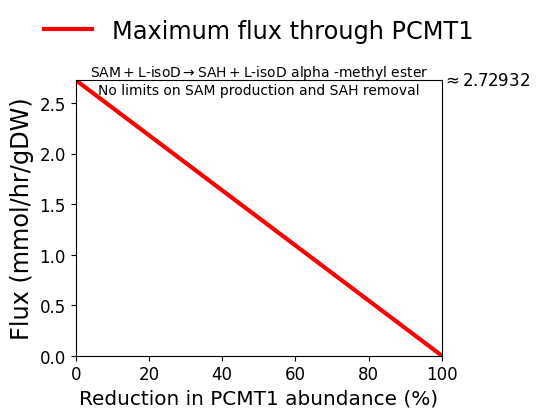

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
PROTISODMT_L_flux = df_solutions.loc[["PROTISODMT_L"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
PROTISODMT_L_flux.index *= -1
PROTISODMT_L_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=3, 
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    "$\\text{SAM} + \\text{L-isoD} \\rightarrow \\text{SAH} + \\text{L-isoD}\ \\text{\\alpha -methyl ester}$" 
    "\nNo limits on SAM production and SAH removal",
    xy=(0.5, 1.00),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="medium"
)


xpad = 0
ypad = 0.001
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(0, PROTISODMT_L_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")

ymax = PROTISODMT_L_flux.max()
ax.annotate(
    approx_label_fmt.format(ymax), 
    xy=(100, ymax *0.98), 
    xycoords="data",
    fontsize="large"
)

fig.tight_layout()
if save_figures:
    ftypes = ["png", "svg"]
    for ftype in ftypes:
        fig.savefig(
            abundance_change_results_path 
            / f"Reduction_{protein_of_interest}_PanelB.{ftype}", 
            transparent=transparent, 
            format=ftype
        )

## Modify rate constants
Assays performed using DSIP peptide with L-isoaspartyl-residue as substrate. Measured by SAH formation
$$\begin{align}
\text{For wildtype:}&& K_\mathrm{m} = 11.34\ \mu M,\ & k_\mathrm{cat} = 856.2\ nmol / min\\
\text{   For V120I:}&& K_\mathrm{m} = 12.54 \mu M,\ & k_\mathrm{cat} = 1184\ nmol / min
\end{align}$$

In [16]:
rid_modk = "PROTISODMT_L"
biochemical_reactions = [rid_modk]
kinetic_parameters = {
    "WT": {
        "kcat_fwd": (
            428.3/500 # nmol product / min / nmol enzyme
            * 60  # min / hr
        ), # mmol product / hr / mmol enzyme
        "Km_fwd": (
            11341 # nmol / L
            * (1 / 1e6) # mmol / nmol
            * ((DEFAULT_VOLUME_PER_CELL * 1e-15) / (DEFAULT_DRY_MASS_PER_CELL * 1e-12)) # L / gCDW
        ), # mmol substrate / gCDW
    },
    "V120I": {
        "kcat_fwd": (
            591.8/500 # nmol product / min / nmol enzyme
            * 60  # min / hr
        ), # mmol product / hr / mmol enzyme
        "Km_fwd": (
            12541 # nmol / L volume
            * (1 / 1e6) # mmol / nmol
            * ((DEFAULT_VOLUME_PER_CELL * 1e-15) / (DEFAULT_DRY_MASS_PER_CELL * 1e-12)) # L / gCDW
        ), # mmol substrate / gCDW
    },
}
modified_pcmodels = {
    variant: {} for variant in list(kinetic_parameters)
}

kinetic_parameters

{'WT': {'kcat_fwd': 51.396, 'Km_fwd': 3.4023e-05},
 'V120I': {'kcat_fwd': 71.016, 'Km_fwd': 3.762300000000001e-05}}

In [17]:
pcmodel_modk = pcmodel.copy()
reaction = pcmodel_modk.reactions.get_by_id(rid_modk)
enzyme_keff = 234000
new_keff = 234000 * (71.016 / 51.396)
cplx_mets_modk = pcmodel_modk.metabolites.get_by_any(cplx_mids)
enzyme_form_rids_modk = [
    x for x in enzyme_form_rids
    if x.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}")
]
for cplx_met_modk in cplx_mets_modk:
    enzyme_form_rids_modk = [
        x for x in enzyme_form_rids
        if x.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}")
    ]
    for enzyme_form_rxn in pcmodel_modk.reactions.get_by_any(enzyme_form_rids_modk):
        complex_keff_coeff = enzyme_form_rxn.get_coefficient(cplx_met_modk) * enzyme_keff
        if enzyme_form_rxn.id.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}{enzyme_fwd_suffix}"):
            enzyme_form_rxn.add_metabolites({cplx_met_modk: -abs(complex_keff_coeff / new_keff)}, combine=False)
        else:
            enzyme_form_rxn.add_metabolites({cplx_met_modk: -abs(complex_keff_coeff / new_keff)}, combine=False)
        print(enzyme_form_rxn)
reaction.add_metabolites(
    dict(
        (mid, -1 * (1 / new_keff / 1e-6)) 
        if mid in reaction.reactants
        else (mid, 1 * (1 / new_keff / 1e-6))
        for mid in enzyme_mids[rid_modk]
    ), 
    combine=False)
print(reaction)

ENZFM_enzyme_PROTISODMT_L_fwd_cplx_MONOMER_PCMT1_pc: 0.2318160030727742 cplx_MONOMER_PCMT1_pc --> enzyme_PROTISODMT_L_fwd_pc
PROTISODMT_L: amet__L_c + protres_isoasp__L_c --> ahcys__L_c + 3.0928385946973305 enzyme_PROTISODMT_L_fwd_pc + 3.0928385946973305 enzyme_PROTISODMT_L_rev_pc + protres_isoaspmeo__L_c


In [18]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
    "PROTDL_protein_MAT2A_pc",
    "RELAX_protein_MAT2A_pc",
    "PROTDL_protein_MAT2B_pc",
    "RELAX_protein_MAT2B_pc",
    "RELAX_protein_AHCY_pc",
    "PROTDL_protein_AHCY_pc",
]
biochemical_rxns_of_interest = ["METAT", "AHC", "SK_protres_isoasp__L_c", "SK_amet__L_c", "DM_protres_isoaspmeo__L_c", "DM_ahcys__L_c"]
objective_reactions = [reaction_of_interest]


solutions = []
with pcmodel_modk:
    pcmodel_modk.reactions.SK_protres_isoasp__L_c.bounds = (-1000, 1000)
    pcmodel_modk.reactions.SK_amet__L_c.bounds = (0, 0)
    pcmodel_modk.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 1000)
    pcmodel_modk.reactions.DM_ahcys__L_c.bounds = (0, 0)
    protein_reaction = pcmodel_modk.reactions.get_by_id(protein_rid)
    pcmodel_modk.objective = sum([rxn.flux_expression for rxn in pcmodel_modk.reactions.get_by_any(objective_reactions)])
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel_modk.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
METAT,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,...,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517
AHC,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,...,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517,0.005517
SK_protres_isoasp__L_c,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,...,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612,-0.005612
SK_amet__L_c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DM_protres_isoaspmeo__L_c,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,...,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612
DM_ahcys__L_c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTISODMT_L,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,...,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612,0.005612
PROTDL_protein_PCMT1_pc,3.716592,3.679426,3.642260,3.605094,3.567928,3.530762,3.493597,3.456431,3.419265,3.382099,...,0.334493,0.297327,0.260161,0.222996,0.185830,0.148664,0.111498,0.074332,0.037166,0.000000
RELAX_protein_PCMT1_pc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_MAT2A_pc,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,...,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593,0.171593


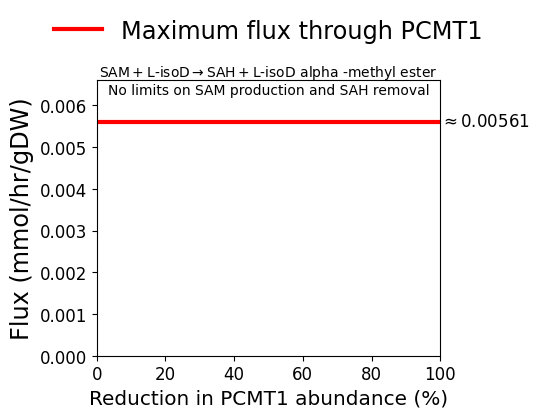

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
PROTISODMT_L_flux = df_solutions.loc[["PROTISODMT_L"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
PROTISODMT_L_flux.index *= -1
PROTISODMT_L_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=3, 
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    "$\\text{SAM} + \\text{L-isoD} \\rightarrow \\text{SAH} + \\text{L-isoD}\ \\text{\\alpha -methyl ester}$" 
    "\nNo limits on SAM production and SAH removal",
    xy=(0.5, 1.00),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="medium"
)


xpad = 0
ypad = 0.001
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(0, PROTISODMT_L_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")

ymax = PROTISODMT_L_flux.max()
ax.annotate(
    approx_label_fmt.format(ymax), 
    xy=(100, ymax *0.98), 
    xycoords="data",
    fontsize="large"
)

fig.tight_layout()
if save_figures:
    ftypes = ["png", "svg"]
    for ftype in ftypes:
        fig.savefig(
            abundance_change_results_path 
            / f"Reduction_{protein_of_interest}_PanelC.{ftype}", 
            transparent=transparent, 
            format=ftype
        )

In [ ]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
    "PROTDL_protein_MAT2A_pc",
    "RELAX_protein_MAT2A_pc",
    "PROTDL_protein_MAT2B_pc",
    "RELAX_protein_MAT2B_pc",
    "RELAX_protein_AHCY_pc",
    "PROTDL_protein_AHCY_pc",
]
biochemical_rxns_of_interest = ["METAT", "AHC", "SK_protres_isoasp__L_c", "SK_amet__L_c", "DM_protres_isoaspmeo__L_c", "DM_ahcys__L_c"]
objective_reactions = [reaction_of_interest]


solutions = []
with pcmodel_modk:
    pcmodel_modk.reactions.SK_protres_isoasp__L_c.bounds = (-10, 0)
    pcmodel_modk.reactions.SK_amet__L_c.bounds = (-10, 0)
    pcmodel_modk.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 10)
    pcmodel_modk.reactions.DM_ahcys__L_c.bounds = (0, 10)
    protein_reaction = pcmodel_modk.reactions.get_by_id(protein_rid)
    pcmodel_modk.objective = sum([rxn.flux_expression for rxn in pcmodel_modk.reactions.get_by_any(objective_reactions)])
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel_modk.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
PROTISODMT_L_flux = df_solutions.loc[["PROTISODMT_L"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
PROTISODMT_L_flux.index *= -1
PROTISODMT_L_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=3, 
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    "$\\text{SAM} + \\text{L-isoD} \\rightarrow \\text{SAH} + \\text{L-isoD}\ \\text{\\alpha -methyl ester}$" 
    "\nNo limits on SAM production and SAH removal",
    xy=(0.5, 1.00),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="medium"
)


xpad = 0
ypad = 0.001
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(0, PROTISODMT_L_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")

ymax = PROTISODMT_L_flux.max()
ax.annotate(
    approx_label_fmt.format(ymax), 
    xy=(100, ymax *0.98), 
    xycoords="data",
    fontsize="large"
)

fig.tight_layout()
if save_figures:
    ftypes = ["png", "svg"]
    for ftype in ftypes:
        fig.savefig(
            abundance_change_results_path 
            / f"Reduction_{protein_of_interest}_PanelD.{ftype}", 
            transparent=transparent, 
            format=ftype
        )

### Using catalytic efficiencies (low substrate concentrations)

In [ ]:
# ptype = "kcat_Km"
# for variant in list(modified_pcmodels):
#     pcmodel_modk = pcmodel.copy()
#     pcmodel_modk.id = "_".join((pcmodel.id, variant, ptype))
#     protein_rxn_modk = pcmodel_modk.reactions.get_by_id(protein_rid)

#     # Set enzyme keff to reflect new kinetic constant
#     reaction = pcmodel_modk.reactions.get_by_id(rid_modk)
#     keff_fwd = (
#         kinetic_parameters[variant]["kcat_fwd"] # 1 / hr
#         / kinetic_parameters[variant]["Km_fwd"] # gDW / mmol substrate
#     ) # gCDW / mmol / hr
#     try:
#         keff_rev = (
#             kinetic_parameters[variant]["kcat_rev"]
#             / kinetic_parameters[variant]["Km_rev"]

#         )
#     except KeyError:
#         keff_rev = keff_fwd


#     print(f"Variant: {variant}")
#     print(f"Rate constants:({keff_fwd}, {keff_rev})")
#     cplx_mets_modk = pcmodel_modk.metabolites.get_by_any(cplx_mids)
#     for cplx_met_modk in cplx_mets_modk:
#         enzyme_form_rids_modk = [
#             x for x in enzyme_form_rids
#             if x.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}")
#         ]
#         for enzyme_form_rxn in pcmodel_modk.reactions.get_by_any(enzyme_form_rids_modk):
#             if enzyme_form_rxn.id.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}{enzyme_fwd_suffix}"):
#                 enzyme_form_rxn.add_metabolites({cplx_met_modk: -keff_fwd / 234000}, combine=False)
#             else:
#                 enzyme_form_rxn.add_metabolites({cplx_met_modk: -keff_rev / 234000}, combine=False)
#             print(enzyme_form_rxn)
    

#     # reaction.add_metabolites(
#     #     dict(
#     #         (mid, -1 * (1 / 234000 / 1e-6)) 
#     #         if mid in reaction.reactants
#     #         else (mid, 1 * (1 / 234000 / 1e-6))
#     #         for mid in enzyme_mids[rid_modk]
#     #     ), 
#     #     combine=False)
#     print(reaction)
#     modified_pcmodels[variant][ptype] = pcmodel_modk
#     print()

### Using catalytic constants

In [ ]:
ptype = "kcat"
for variant in list(modified_pcmodels):
    pcmodel_modk = pcmodel.copy()
    enzyme_keff = 234000
    reaction = pcmodel_modk.reactions.get_by_id(rid_modk)
    
    keff_fwd = (
        enzyme_keff
        * kinetic_parameters[variant]["kcat_fwd"] / kinetic_parameters["WT"]["kcat_fwd"]
    ) # gCDW / mmol / hr
    try:
        kcat_rev = (
            enzyme_keff
            * kinetic_parameters[variant]["kcat_rev"] / kinetic_parameters["WT"]["kcat_rev"]
        ) # gCDW / mmol / hr
    except KeyError:
        keff_rev = keff_fwd
    
    cplx_mets_modk = pcmodel_modk.metabolites.get_by_any(cplx_mids)
    enzyme_form_rids_modk = [
        x for x in enzyme_form_rids
        if x.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}")
    ]
    for cplx_met_modk in cplx_mets_modk:
        enzyme_form_rids_modk = [
            x for x in enzyme_form_rids
            if x.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}")
        ]
        for enzyme_form_rxn in pcmodel_modk.reactions.get_by_any(enzyme_form_rids_modk):
            complex_keff_coeff = enzyme_form_rxn.get_coefficient(cplx_met_modk) * enzyme_keff
            if enzyme_form_rxn.id.startswith(f"{enzyme_form_prefix}{enzyme_met_prefix}{rid_modk}{enzyme_fwd_suffix}"):
                enzyme_form_rxn.add_metabolites({cplx_met_modk: -abs(complex_keff_coeff / enzyme_keff)}, combine=False)
            else:
                enzyme_form_rxn.add_metabolites({cplx_met_modk: -abs(complex_keff_coeff / enzyme_keff)}, combine=False)
            print(enzyme_form_rxn)
    reaction.add_metabolites(
        dict(
            (mid, -1 * (1 / enzyme_keff / 1e-6)) 
            if mid in reaction.reactants
            else (mid, 1 * (1 / enzyme_keff / 1e-6))
            for mid in enzyme_mids[rid_modk]
        ), 
        combine=False)
    print(reaction)
    modified_pcmodels[variant][ptype] = pcmodel_modk
    print()

## Optimal fluxes as a function of reduction in protein abundance

In [ ]:
percent_interval = (0, -10)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
]
biochemical_rxns_of_interest = []
objective_reactions = ["PROTISODMT_L"]

solutions_dict = defaultdict(dict)


for variant, models_dict in modified_pcmodels.items():
    for key, pcmodel_modk in models_dict.items():
        print(variant)
        solutions = []
        with pcmodel_modk:
            protein_reaction = pcmodel_modk.reactions.get_by_id(protein_rid)
            pcmodel_modk.objective = sum([rxn.flux_expression for rxn in pcmodel_modk.reactions.get_by_any(objective_reactions)])
            pcmodel_modk.reactions.SK_protres_isoasp__L_c.bounds = (-1000, 1000)
            pcmodel_modk.reactions.SK_amet__L_c.bounds = (-1000, 0)
            pcmodel_modk.reactions.DM_protres_isoaspmeo__L_c.bounds = (0, 1000)
            pcmodel_modk.reactions.DM_ahcys__L_c.bounds = (0, 1000)
            
            for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
                protein_reaction.bounds = (
                    orig_protein_bounds[0] * (1 + percent/100),
                    orig_protein_bounds[1] * (1 + percent/100),
                )
                sol = pcmodel_modk.optimize()
                sols_of_interest = sol.fluxes.loc[
                    biochemical_rxns_of_interest
                    + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
                    + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
                ]
                sols_of_interest.name = percent
                solutions.append(sols_of_interest)
        
        df_solutions = pd.concat(solutions, axis=1)
        solutions_dict[variant][key] = df_solutions
        print()

In [ ]:
# ptype = "kcat_Km"
# solutions_dict["WT"][ptype]

In [ ]:
# ptype = "kcat_Km"
# solutions_dict["V120I"][ptype]

In [ ]:
ptype = "kcat"
solutions_dict["WT"][ptype]

In [ ]:
ptype = "kcat"
solutions_dict["V120I"][ptype]